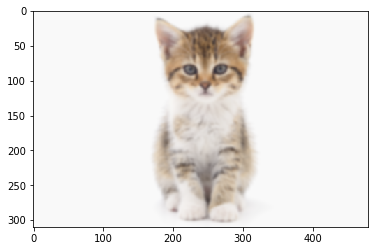

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


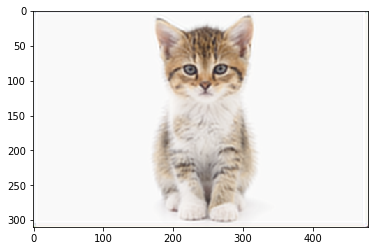

In [14]:
import torch
import torchvision
import cv2
import torchvision.transforms as transform
import torchvision.datasets as dtst
import torch.utils as utils
from matplotlib import pyplot

criterion=torch.nn.MSELoss()


def initialize_dataloader(path="./tr/"):
    transformation=transform.Compose([transform.ToTensor(),transform.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
    traindata=dtst.ImageFolder(root=path,transform=transformation)
    traindataloader=utils.data.DataLoader(traindata,batch_size=64,shuffle=True,num_workers=4)
    return traindataloader

# 256x256x3
class SRCNN(torch.nn.Module):
  def __init__(self):
    super(SRCNN,self).__init__()
    self.network=[]
    self.network+=[torch.nn.Conv2d(3,64,9,padding=4),torch.nn.ReLU(inplace=True) , torch.nn.Conv2d(64,32,5,padding=2) , torch.nn.ReLU(inplace=True) , torch.nn.Conv2d(32,3,5,padding=2)  ]
    self.network=torch.nn.Sequential(*self.network)
  def forward(self,input):
    return self.network(input)


def show(tensor):
  tensor=(tensor.cpu().numpy().transpose(1,2,0))
  pyplot.imshow(tensor)
  pyplot.show()

def start(hardware="gpu",data_path="./tr/",pkl_path="./",pre_trained=False,tensor=torch.tensor([])):
  net=SRCNN()
  if(hardware=="gpu"):
    net=net.cuda()
  else:
    pass

  if(pre_trained):
    net.load_state_dict(torch.load(pkl_path))
    show(tensor[0])
    show(net(tensor)[0].detach())
  else:
    optimizer=torch.optim.Adam(net.parameters(),lr=0.0001)
    dataloader=initialize_dataloader(data_path)
    for epoch in range(1000):
      for input,_ in dataloader:
        criterion.zero_grad()
        optimizer.zero_grad()
        original=(input[:,:,:,:256]+1)/2
        blurred=(input[:,:,:,256:]+1)/2
        if(hardware=="gpu"):
          original=torch.autograd.Variable(original).cuda()
          blurred=torch.autograd.Variable(blurred).cuda()
        else:
          original=torch.autograd.Variable(original)
          blurred=torch.autograd.Variable(blurred)
        forward=net(blurred)
        loss=criterion(forward,original)
        loss.backward()
        optimizer.step()
      if(epoch%25==0):
        print("Error rate : {}".format(loss))
        show(original[0])
        show(forward[0].detach())
    torch.save(net.state_dict(),"srcnn_{}.pkl".format(epoch))
  

test=cv2.imread("image.png")
test=cv2.cvtColor(test,cv2.COLOR_BGR2RGB)
test=torch.tensor(test.transpose(2,0,1)/255,dtype=torch.float).unsqueeze(0)
#test=test.cuda()
start(hardware="cpu",pkl_path="srcnn_500.pkl",pre_trained=True,tensor=test)
